In [15]:
import os
import glob

import pandas as pd
import numpy as np
from collections import defaultdict
import random

import matplotlib.pyplot as plt
from PIL import Image

import torch
from torch import nn, optim, functional
from torchvision import transforms

from torchvision.utils import make_grid
from torchvision.io import decode_image

from torchvision_plotting import plot as helpers_plot
from torch.utils.data import Dataset, DataLoader
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
from torchsummary import summary

random.seed(15)

### Import film and digital data

In [16]:
class ImageDataset(Dataset):
    def __init__(self, file_list, apply_transform = None,  film_or_digital = "digial"):
        "Apply transform must be a transform object"

        self.file_paths = file_list
        self.apply_transform = apply_transform
        self.film_or_digital = film_or_digital

    def __len__(self):
        return len(self.file_paths)
    
    def __getitem__(self, idx):
        img_path = self.file_paths[idx]

        image = Image.open(img_path).convert("RGB")


        #Make sure to align film or digital transformations correctly"
        if self.apply_transform:
            image = self.apply_transform(image)
        else:
            #We skip the application of 
            pass
        return image
    


In [17]:
class DatasetPreparation():

    def __init__(self):

        resize_dims = (256, 256) if "device" != "cpu" else (128, 128)

        self.film_image_transforms = nn.Sequential(
            transforms.v2.Resize(resize_dims), 
            transforms.v2.ToTensor(), 
            transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
        )

        #Implementing image transformations to expand images we are using
        self.digital_image_transforms = nn.Sequential(
            transforms.v2.Resize(resize_dims), 
            transforms.v2.RandomHorizontalFlip(p = 0.2),
            transforms.v2.RandomVerticalFlip(p = 0.2), 
            transforms.v2.ToTensor(), 
            transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225])
        )


        self.test_set_image_transforms = nn.Sequential(transforms.v2.Resize(resize_dims),
                                                transforms.v2.ToTensor(), 
                                                transforms.v2.Normalize(mean = [0.485, 0.456, 0.406],  std =[0.229, 0.224, 0.225]))


    def dataset_splitting_preparation(self, data_paths, 
                                    split_portions = (.80, .10, .10),
                                    pic_type = 'digital'):
        full_amnt = len(data_paths)
        
        train_amnt = int(split_portions[0] * full_amnt)
        val_amnt = int(split_portions[1] * full_amnt)
        test_amnt = int(split_portions[2] * full_amnt)

        assert split_portions[0] + split_portions[1] + split_portions[2] == 1.0, "Train, Val, test splits do not sum to 1"
        

        random.shuffle(data_paths)

        train_data = data_paths[:train_amnt]
        val_data = data_paths[train_amnt:val_amnt + train_amnt]
        test_data = data_paths[val_amnt + train_amnt:]

        if pic_type == 'digital':        
            train_image_data = ImageDataset(file_list = train_data, apply_transform=self.digital_image_transforms, film_or_digital = pic_type)
            val_image_data = ImageDataset(file_list = val_data, apply_transform=self.digital_image_transforms, film_or_digital = pic_type)
        elif pic_type == 'film':
            train_image_data = ImageDataset(file_list = train_data, apply_transform=self.film_image_transforms, film_or_digital = pic_type)
            val_image_data = ImageDataset(file_list = val_data, apply_transform=self.film_image_transforms, film_or_digital = pic_type)
        else:
            raise TypeError("Incorrect picture format provided")

        #All test image data dets the same standard transformations. Just resizing, normalization RGB values
        test_image_data = ImageDataset(file_list = test_data, apply_transform=self.test_set_image_transforms, film_or_digital = pic_type)



        return train_image_data, val_image_data, test_image_data



In [18]:
film_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/film_photos"
film_paths = glob.glob(film_paths + "/*.jpeg") # Grabbing all the image file names

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), film_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

digital_paths = "/Users/cody_schiffer/Personal_Projects/filmify!/digital_photos"
digital_paths = glob.glob(digital_paths + "/*.jpeg")

# _, axes = plt.subplots(4, 4, figsize=(10, 10))
# for ax, img_path in zip(axes.flatten(), digital_paths):
#     ax.imshow(Image.open(img_path))
#     ax.axis("off")

#Limit data for cpu testing
if device == "cpu":
    film_paths = film_paths[:50]
    digital_paths = digital_paths[:50]

split_scheme = (.80,.10,.10)

prepare_data = DatasetPreparation()

film_train, film_val, film_test = prepare_data.dataset_splitting_preparation(film_paths,
                                                                split_portions = split_scheme,
                                                                pic_type="film")


digital_train, digital_val, digital_test = prepare_data.dataset_splitting_preparation(digital_paths,
                                                                        split_portions = split_scheme,
                                                                        pic_type="digital")




/Users/cody_schiffer/anaconda3/envs/a-alpha-conda/lib/python3.10/site-packages/torchvision/transforms/v2/_deprecated.py:41: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


Film Training data
Digital Training Data


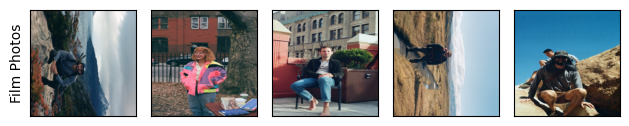

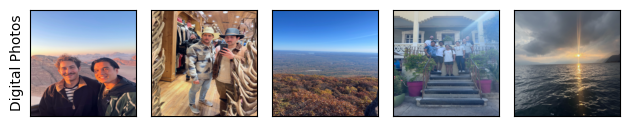

In [19]:
#Show the image transformations
print("Film Training data")
new_images = [film_train[i] for i in range(10, 15)] 
helpers_plot(new_images, row_title = ["Film Photos"])

print("Digital Training Data")
new_images = [digital_train[i] for i in range(10, 15)]
helpers_plot(new_images, row_title = ["Digital Photos"])




In [20]:
#Lets create our dataloaders
if device.type == "cpu":
    batch_size = 1 #should be hyperparameter tuned given normalization strategies
    norm_type = "instance"
else:
    batch_size = 10
    norm_type = "batch"

drop_uneven_batches = True

film_train_DL = DataLoader(film_train, batch_size = batch_size, drop_last = True if drop_uneven_batches else False)
film_val_DL = DataLoader(film_val, batch_size = batch_size, drop_last = False)
film_test_DL = DataLoader(film_test, batch_size=batch_size, drop_last = False)

digital_train_DL = DataLoader(digital_train, batch_size = batch_size, drop_last = True if drop_uneven_batches else False)
digital_val_DL = DataLoader(digital_val, batch_size = batch_size, drop_last = False)
digital_test_DL = DataLoader(digital_test, batch_size = batch_size, drop_last = False)


#### Architecture time! Move these over when you're done with experimentation :) 

In [22]:
# from modelling import PatchGANDiscriminator, EncoderDecoderSkipConnection
# from torch import optim


class ResidualBlock(nn.Module):
    def __init__(self, channels, select_nonlinearity="leaky", use_batchnorm = False):
        super().__init__()
        
        self.channels = channels
        self.select_nonlinearity = select_nonlinearity

        #We are not adjusting the channel sizes for the residual net as that requires
        #An additional transformation
        self.res_conv2d = nn.Conv2d(in_channels=self.channels, 
                                                    out_channels = self.channels,
                                                    kernel_size = 3, 
                                                    stride = 1, 
                                                    padding = 1, 
                                                    bias = False if use_batchnorm else True)
                                    
        self.res_batchnorm2d = nn.BatchNorm2d(self.channels)
        
        if select_nonlinearity.lower() == "relu":
            self.nonlinearity_func = nn.ReLU(inplace=True)
        elif select_nonlinearity.lower()  == "tanh":
            self.nonlinearity_func = nn.Tanh()
        elif select_nonlinearity.lower()  == "leaky":
            self.nonlinearity_func = nn.LeakyReLU(inplace=True)
        else:
            self.nonlinearity_func = nn.ReLU(inplace = True)

        
        if use_batchnorm:
            self.res_batchnorm2d = nn.BatchNorm2d(self.channels)
            self.residual_block = nn.Sequential(self.res_conv2d,
                                                self.res_batchnorm2d,
                                                self.nonlinearity_func,
                                                self.res_conv2d,
                                                self.res_batchnorm2d
                                                )
        else:
            self.residual_block = nn.Sequential(self.res_conv2d,
                                                self.nonlinearity_func,
                                                self.res_conv2d,
                                                )
            
    def forward(self, x):

        """Residual connections help the flow of gradients across the data it is defined as F(x) = H(x) - x
        Which can be re-written as H(x) = F(x) + X. Here the model just needs to learn difference represented by 
        Make sure to print out the activation function
        """


        #"x + self.residual_block(x)" is the "shortcut". We're learning the difference 
        out = self.residual_block(x)
        return self.nonlinearity_func(x+out)
        

class Encoder(nn.Module):
    def __init__(self, start_channels = 3,
                encoder_depth = 4,
                select_nonlinearity = "leaky", 
                ):

        super().__init__()

        self.start_channels = start_channels
        self.encoder_depth = encoder_depth
        self.select_nonlinearity = select_nonlinearity
                                            
    
        #Logic for automating the in_channels and out_channels
        channels_flow = [(256 / encoder_depth * i, (256 / encoder_depth * i)/2) for i in range(1,encoder_depth+1)]
        channels_flow = channels_flow[::-1]

        if self.select_nonlinearity.lower() == "relu":
            self.nonlinearity_func = nn.ReLU(inplace=True)
        elif self.select_nonlinearity.lower() == "tanh":
            self.nonlinearity_func = nn.Tanh()
        elif self.select_nonlinearity.lower() == "leaky":
            self.nonlinearity_func = nn.LeakyReLU(inplace=True)

        

        self.encoder = nn.Sequential(nn.Conv2d(in_channels=start_channels, 
                                            out_channels = 64,
                                            kernel_size = 4,
                                            stride = 2,
                                            padding=1),
                                    self.nonlinearity_func,
                                    nn.Conv2d(in_channels = 64, 
                                            out_channels= 128,
                                            kernel_size=4,
                                            stride = 2,
                                            padding = 1),
                                    nn.BatchNorm2d(128),
                                    self.nonlinearity_func
                                    )
        
    # def __repr__(self):
    #     """Prints the class representation"""

    #     return f"Encoder(encoder ={self.encoder})"

    #     print()
        
    def forward(self, x):
        
        return self.encoder(x)

class Decoder(nn.Module):
    def __init__(self, start_channels, 
                select_intermediate_nonlinearity = "leaky",
                select_ending_nonlinearity = "tanh", 
                norm_type = None,
                final_layer_dims = 3):
        
        super().__init__()

        all_layers = []

        #Start channels must match the preceding channel work
        all_layers += [nn.ConvTranspose2d(in_channels = start_channels,
                                        out_channels = 64,
                                        kernel_size = 4,
                                        stride = 2,
                                        padding =1)]
        

        if norm_type == "layer":
            """Layer normalization gets messy. You need to permute the dimensions as layer norm will work on las """
            normalization_layer = nn.LayerNorm(64)
            all_layers += normalization_layer
        elif norm_type == "batch":
            normalization_layer = nn.BatchNorm2d(64)
            all_layers += normalization_layer
        elif norm_type == "instance":
            normalization_layer = nn.InstanceNorm2d(64)
            all_layers += normalization_layer
        else: 
            "Skip the normalization layer"
            pass


        if select_intermediate_nonlinearity.lower() == "relu":
            all_layers += [nn.ReLU(inplace=True)]
        elif select_intermediate_nonlinearity.lower() == "tanh":
            all_layers += [nn.Tanh()]
        elif select_intermediate_nonlinearity.lower() == "leaky":
            all_layers += [nn.LeakyReLU(inplace=True)]



        final_upsample = nn.ConvTranspose2d(in_channels = 64, out_channels = final_layer_dims, kernel_size=4, stride=2, padding=1)

        all_layers += [final_upsample]

        if select_ending_nonlinearity == "tanh":
            all_layers += [nn.Tanh()]

        ##Create the sequential
        self.decoder = nn.Sequential(*all_layers)


    def forward(self, x):
  
        return self.decoder(x)
    

class EncoderDecoderSkipConnection(nn.Module):

    def __init__(self, first_channels, res_blocks = 6):

        super().__init__()


        #TODO adjust automatic readout of channels from encoder -> res_blocks
        encoder = Encoder(start_channels=first_channels, 
                          select_nonlinearity="leaky")
        decoder = Decoder(start_channels = 128, 
                            select_intermediate_nonlinearity="leaky",
                            select_ending_nonlinearity="tanh",
                            norm_type=None)
        # Residual blocks
        residuals = nn.Sequential(*[ResidualBlock(128, select_nonlinearity="leaky") for _ in range(res_blocks)])

        ###Equivalent to: 
        """
        nn.Sequential(
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128),
            ResidualBlock(128)
        )
        """

        self.encoder_resblock_decoder = nn.Sequential(encoder, residuals, decoder)


    def forward(self, x):
        x = self.encoder_resblock_decoder(x)
        return x



class PatchGANDiscriminator(nn.Module):

    def __init__(self, in_channels):
        """Lets just implement a basic version of this"""
        super().__init__()

        self.patchgan = nn.Sequential(
                                    nn.Conv2d(in_channels, out_channels = 64, kernel_size = 4, stride = 2, padding =1),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 4, stride = 2, padding = 1),
                                    nn.BatchNorm2d(128),
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.Conv2d(in_channels = 128, out_channels = 256, stride = 2, kernel_size = 4, padding = 1),
                                    nn.BatchNorm2d(256), 
                                    nn.LeakyReLU(0.2, inplace = True),
                                    nn.Conv2d(in_channels = 256, out_channels = 1, stride = 1, kernel_size = 4, padding = 1),
                                    nn.Sigmoid() 
                                    )
        
        "patchGANs downsample the photo and "


    def forward(self,x):
        return self.patchgan(x)



In [23]:
#Initializing the models
epochs = 10
learning_rate = 0.001

adversarial_loss = nn.BCELoss()
cycle_loss = nn.L1Loss() #Why not use L2Loss()/MSELoss()
identity_loss = nn.L1Loss() #Why not use L2LosS()/MSELoss()

generator = EncoderDecoderSkipConnection(first_channels = 3, res_blocks = 3) #Add standardized output_channel
discriminator = PatchGANDiscriminator(in_channels = 3) #Input channels here must match the output of the decoder above

gen_optimizer = optim.Adam(generator.parameters(), lr = learning_rate)
discr_optimizer = optim.Adam(discriminator.parameters(), lr = learning_rate)

generator.to(device)
discriminator.to(device)

print(generator)

print("_______________________")

print(discriminator)


EncoderDecoderSkipConnection(
  (encoder_resblock_decoder): Sequential(
    (0): Encoder(
      (nonlinearity_func): LeakyReLU(negative_slope=0.01, inplace=True)
      (encoder): Sequential(
        (0): Conv2d(3, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (1): LeakyReLU(negative_slope=0.01, inplace=True)
        (2): Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
        (3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (4): LeakyReLU(negative_slope=0.01, inplace=True)
      )
    )
    (1): Sequential(
      (0): ResidualBlock(
        (res_conv2d): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (res_batchnorm2d): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (nonlinearity_func): LeakyReLU(negative_slope=0.01, inplace=True)
        (residual_block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), pad

In [24]:
#Parameter counting 
gen_layers = len([layer for layer in generator.modules()])
print(f"Layers in Generator: {gen_layers}")
gen_params = [p for layer in generator.modules() for p in layer.parameters()]
gen_total_params = sum(p.nelement() for p in gen_params) #nelement() = total number of elements in the input tensor
print(f"params in Generator: {gen_total_params}")


discr_layers = len([layer for layer in discriminator.modules()])
print(f"Layers in Discriminator: {discr_layers}")
discr_params = [p for layer in discriminator.modules() for p in layer.parameters()]
discr_total_params = sum(p.nelement() for p in discr_params)
print(f"params in Discrminator: {discr_total_params}")



Layers in Generator: 30
params in Generator: 4004367
Layers in Discriminator: 12
params in Discrminator: 1991235


In [ ]:
device.type

'cpu'

In [ ]:
digital_train_DL.dataset[2].shape
film_train_DL.dataset[1].shape

torch.Size([3, 256, 256])

In [ ]:
#Run the training loop

if device.type == 'cpu':
    epochs = 10
else:
    epochs = 100

cycle_loss_weight = .10
identity_loss_weight = .05

epoch_pics = defaultdict(list)
epoch_gen_losses = defaultdict(list)
epoch_discr_losses = defaultdict(list)

epoch_pics = []
epoch_gen_losses = []
epoch_discr_losses = []

for epoch in range(epochs):
    subepoch_pics = []
    subepoch_gen_losses = []
    subepoch_discr_losses = []
    #Note that the zip function will cut the dataloaders at the maximum for either. Surplus photos of either class will not be considered
    counter = 0
    for real_digital, real_film in zip(digital_train_DL, film_train_DL):
        real_digital.to(device)
        real_film.to(device)

        ## Labels for real and fake images 

        #Dynamic method is to forward through the patchgan discriminator and get output shappe
        # Dummy input with the same size as your real images
        expected_shape = real_digital[:1].shape
        dummy_input = torch.randn(expected_shape)# (batch_size, channels, height, width)

        # Forward pass to get output shape
        output_shape = discriminator(dummy_input).shape  # (batch_size, 1, height, width)

        # Labels for real and fake images TODO:  # Adjust based on PatchGAN output size
        real_labels = torch.ones(output_shape, device=device) 
        fake_labels = torch.zeros(output_shape, device=device)

        ##Training
        #zero the grads
        gen_optimizer.zero_grad()

        fake_film = generator(real_digital) #digital -> film transformation

        gen_adversarial_loss = adversarial_loss(discriminator(fake_film),  real_labels)

        #Cycle-consistency_loss
        new_digital = generator(fake_film)
        g_cycle_loss = cycle_loss(new_digital, real_digital)
        g_identity_loss = identity_loss(new_digital, real_digital)


        #Total generator loss
        if 
        gen_loss = gen_adversarial_loss + (g_cycle_loss * cycle_loss_weight) + (identity_loss*identity_loss_weight)
        
        """
        append the overall adversarial generator loss, the adversarial loss, the cycle loss, and then the identity loss
        """
        subepoch_gen_losses.append([gen_loss, gen_adversarial_loss, g_cycle_loss, identity_loss])
    
        gen_loss.backward()
        gen_optimizer.step()

        ##Discriminator
        discr_optimizer.zero_grad()


        """The discriminator processes the fake (generated) images. 
        The .detach() ensures that gradients from the discriminator's loss 
        do not propagate back to the generator during this step.
        """
        discr_real_loss = adversarial_loss(discriminator(real_film), real_labels)
        discr_fake_loss = adversarial_loss(discriminator(fake_film.detach()), fake_labels)


        discr_loss = (discr_real_loss + discr_fake_loss) /2 
        
        """Append the overall discriminator loss,
        the discriminator loss on real images,
        the discriminator loss on fake images to epoch level tracking
        """
        subepoch_discr_losses.append([ discr_loss, discr_real_loss, discr_fake_loss])
        
        
        discr_loss.backward()
        discr_optimizer.step()

        # ----------------------
        #  Logging
        # ----------------------
        if len(digital_train_DL) > 500:
            progress_report_threshold = 100

        if counter % progress_report_threshold == 0:
            print(f"[Epoch {epoch}/{epochs}] [Batch {pos}/{len(digital_train_DL)}] "
                  f"[D loss: {discr_loss.item():.4f}] [G loss: {gen_loss.item():.4f}]"
            )

        counter += 1



    

In [ ]:
#Lets see what images the train model produces after finishing training
from torch.utils.data import Subset

random_pics = random.sample(range(len(digital_train_DL)), 5)
sub_sample = digital_train_DL[random_pics]

subset_ds = Subset(digital_train_DL)

helpers_plot(subset_ds, row_title = ["Film Photos"])

### Lets run val loops

In [ ]:

@torch.no_grad()
def loss_test_evaluations(digital_DL, film_DL):
    
    generative_loss = []
    discriminator_loss = []

    all_generated_films = []
    shorter_dataset = digital_DL if len(digital_DL) >= len(film_DL) else film_DL

    for pos, (real_digital, real_film) in enumerate(zip(digital_DL, film_DL)):
        
        if pos % 25 == 0:
            print(f"{pos}/{len(shorter_dataset)}")

        generator.eval()
        discriminator.eval()
        
        #move inputs to the device, either cuda or cpu
        real_digital.to(device)
        real_film.to(device)
    
        #Generating the film
        fake_film = generator(real_digital)

        # Dummy input with the same size as your real images
        expected_shape = real_digital[:1].shape
        dummy_input = torch.randn(expected_shape)# (batch_size, channels, height, width)

        # Forward pass to get output shape
        expected_output_shape = discriminator(dummy_input).shape  # (batch_size, 1, height, width)

        # Labels for real and fake images TODO:  # Adjust based on PatchGAN output size
        real_labels = torch.ones(expected_output_shape, device=device) 
        fake_labels = torch.zeros(expected_output_shape, device=device)

        gen_adversarial_loss = adversarial_loss(discriminator(fake_film), real_labels)


        #cycle-consistency_loss
        new_digital = generator(fake_film)
        g_cycle_loss = cycle_loss(new_digital, real_digital)

        #Total generator loss
        gen_loss = gen_adversarial_loss + (g_cycle_loss * cycle_loss_weight) + (identity_loss*identity_loss_weight)
        
        generative_loss.append(gen_loss)

        #Discriminator
        discr_real_loss = adversarial_loss(discriminator(real_film), real_labels)
        discr_fake_loss = adversarial_loss(discriminator(fake_film.detach()), fake_labels)


        discr_loss = (discr_real_loss + discr_fake_loss) /2 

        discriminator_loss.append(discr_loss)

        all_generated_films.append(fake_film)


    #Lets return the average and median loss
    gen_loss_mean = torch.stack(generative_loss).mean().item()
    discriminator_loss_mean = torch.stack(discriminator_loss).mean().item()
    gen_loss_median = torch.stack(generative_loss).median().item()
    discriminator_loss_median = torch.stack(discriminator_loss).median().item()


    print(f"Average loss for generator: {gen_loss_mean:.4f}")
    print(f"Median loss for generator: {gen_loss_median:.4f}")

    print("||||||||||||||||||||||||||||||||||||||||||||||||||")

    print(f"Average loss for generator: {discriminator_loss_mean:.4f}")
    print(f"Median loss for generator: {discriminator_loss_median:.4f}")

    return generative_loss, discriminator_loss, all_generated_films


gen_loss, discr_loss, gen_films = loss_test_evaluations(digital_DL=digital_test_DL, film_DL=film_test_DL)




